## Extract image features from a patch

In [1]:
import numpy as np
import scipy.io as io
import h5py
import deepdish as dd
import dask.array as da
import os

import skimage
from skimage import io, color

import pycircstat as pyc
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
h5path = '../../H5data/M2'
fname = os.listdir(h5path)
thisfile = fname[2]
print fname

['Bo130828_s92a_v4fv_hues_0003_nev.h5', 'Bo130828_s92a_v4fv_hues_0004_nev.h5', 'Bo130828_s92a_v4fv_orig_0005_nev.h5', 'Bo130828_s92a_v4fv_orig_0006_nev.h5', 'Bo130828_s92a_v4fv_orig_0007_nev.h5', 'Bo130828_s92a_v4fv_orig_0008_nev.h5', 'Bo130829_s93a_v4fv_eqlum_0004_nev.h5', 'Bo130829_s93a_v4fv_hues_0003_nev.h5', 'Bo130829_s94a_v4fv_hues_0004_nev.h5', 'Bo130829_s94a_v4fv_randlum_0005_nev.h5', 'Bo130829_s94a_v4fv_randlum_0006_nev.h5']


### Read in using deepdish

In [3]:
### Read in using deepdish
dat = dd.io.load(h5path+'/'+thisfile)

### Manipulate spike data

In [4]:
## Show first ten spike times for unit 5401
dat['spikes']['5401'][:10]

array([ 0.0933    ,  0.10886667,  0.13326667,  0.17386667,  0.24173333,
        0.25533333,  0.34463333,  0.34813333,  0.355     ,  0.3851    ])

In [5]:
dat['eyes'][0]['impath']

'stimuli/M2/Orig'

### Define useful functions

In [71]:
def get_hue_image(I):
    # Convert to Luv
    Luv = color.rgb2luv(I/255.0)
    # Extract hue
    hue = np.arctan2(Luv[:,:,2], Luv[:,:,1])
    return hue

In [72]:
def visualize_hue_image(I):
    # Convert to Luv
    Luv = color.rgb2luv(I/255.0)
    
    # Assign lum channel to a constant
    Luv[:,:,0] = 30.0*np.ones([Luv.shape[0], Luv.shape[1]])

    # Convert back to RGB just to visualize
    Iviz = color.luv2rgb(Luv)
    
    return Iviz

In [103]:
def show_hue(ax, hue, Nbins=25, polar=False):
    huehist, bin_edges = np.histogram(hue, bins=Nbins, range=(-np.pi, np.pi))
    
    ax.bar(bin_edges[:Nbins]+(bin_edges[1]-bin_edges[0])/2, huehist, width=0.2, edgecolor='g', color='g')
    ax.hold
    if polar == True:
        ax.plot(bin_edges+(bin_edges[1]-bin_edges[0])/2, 1.2*np.max(huehist)*np.ones(len(huehist)+1), color='k')
    mean_hue = stats.circmean(hue, high=np.pi, low=-np.pi)
    ax.plot(mean_hue, 1.2*np.max(huehist), 'r*')
    ax.axis('off')

In [75]:
def grid_image(I, gridshape):
    R = gridshape[0]
    C = gridshape[1]
    b_rows = np.int(np.floor(I.shape[0]/R))
    b_cols = np.int(np.floor(I.shape[1]/C))
    Block = np.zeros([R * C, b_rows, b_cols, I.shape[2]])
    count = 0
    for i in range(R):
        for j in range(C):
            Block[count :, :, :] = I[b_rows * i:b_rows * (i+1), b_cols * j:b_cols *(j+1), :]
            count += 1
    return Block

### Manipulate image data
Use this codeblock to loop through fixations

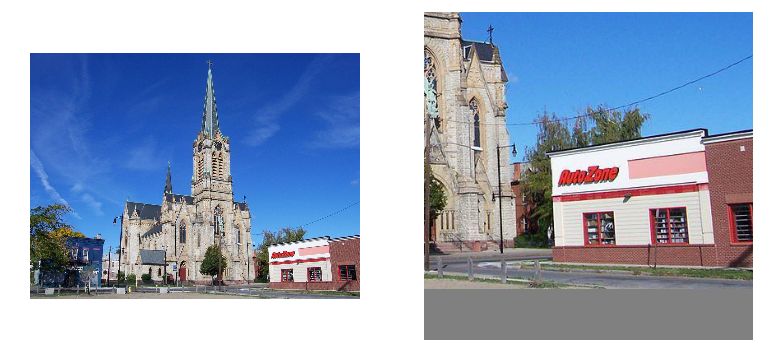

In [85]:
# Extract a patch of arbitrary radius around a fixation
projectpath = '../..'
fx = 100

# Read in the image
impath = dat['eyes'][fx]['impath']
imname = dat['eyes'][fx]['imname']
filename = projectpath+'/'+impath+'/'+imname
I = io.imread(filename)

# Pad the image
[H,W,D] = I.shape
I_pad = 128*np.ones([3*H, 3*W, D])
I_pad[H-1:2*H-1,W-1:2*W-1,0] = I[:,:,0]
I_pad[H-1:2*H-1,W-1:2*W-1,1] = I[:,:,1]
I_pad[H-1:2*H-1,W-1:2*W-1,2] = I[:,:,2]

# Get gaze location
r = int(dat['eyes'][fx]['row'])
c = int(dat['eyes'][fx]['col'])

# If gaze is within the image borders
if(r>0 and r<768 and c>0 and c<1024):
    # Extract patch
    R = 200 #radius
    G = np.zeros([2*R, 2*R, 3])
    G = I_pad[r+H-R:r+H+R, c+W-R:c+W+R, :]
    
    # Show patch
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(I)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(np.uint8(G))
    plt.axis('off')
    plt.show()
    
    # Extract hsl features
else:
    print r,c
    print 'outside'

### Extract hue and map it back to rgb for visualization

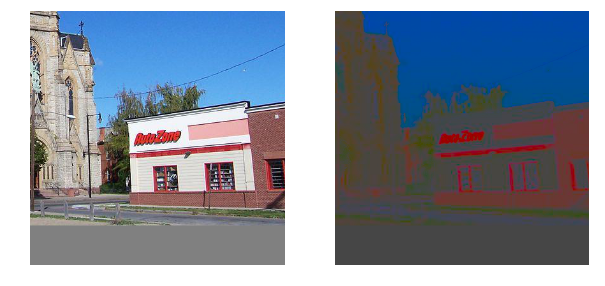

In [95]:
# Extract hue
hue = get_hue_image(G)

# Visualize hue image
Gviz = visualize_hue_image(G)

# Show images
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(np.uint8(G))
plt.axis('off')

plt.subplot(122)
plt.imshow(np.uint8(255.0*Gviz))
plt.axis('off')
plt.show()


### Grid the image and extract hue features from the grid

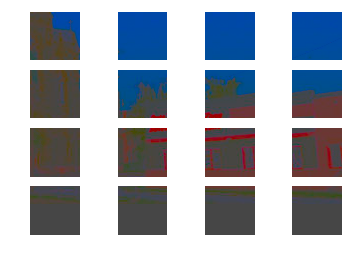

In [104]:
# Grid the image and check if it's correct
G_block = grid_image(G, [4, 4])
plt.figure()
for grd in range(1, 17):
    plt.subplot(4,4,grd)
    Gviz = visualize_hue_image(G_block[grd-1,:,:,:])
    plt.imshow(np.uint8(255.0*Gviz))
    plt.axis('off')
plt.show()

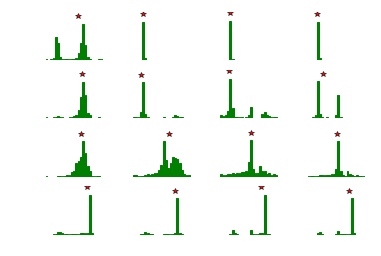

In [105]:
# Compute histogram and circular mean of hue for gridded image
plt.figure()
for grd in range(1, 17):
    hue = get_hue_image(G_block[grd-1,:,:,:])
    ax = plt.subplot(4,4,grd, polar=False)
    show_hue(ax, hue)
plt.show()

### Checking some color space things

In [76]:
imtest = np.zeros([2,2,3])
imtest[0,0,:] = [0.1, 0.2, 0.3]
imtest[0,1,:] = [0.3, 0.2, 0.1]
imtest[1,0,:] = [0.3, 0.2, 0.1]
imtest[1,1,:] = [0.3, 0.2, 0.1]
%timeit color.rgb2luv(imtest)
%timeit color.rgb2hsv(imtest)

The slowest run took 5.33 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 128 µs per loop
10000 loops, best of 3: 109 µs per loop
